In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import CancerDataset_global_pooled_multi_datasets_all
from sklearn.metrics import matthews_corrcoef
import DatasetTransform_global_pooled_all
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.svm import SVC
from sklearn import svm
from sklearn import metrics
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from imblearn.over_sampling import SMOTE
import time
import pandas as pd
import os
dir_path = os.path.dirname(os.path.abspath(os.curdir))

In [2]:
#Input datasets for Pretraining
Tr_CancerProjects=["TCGA-BRCA","TCGA-KIRC","TCGA-KIRP","TCGA-LIHC","TCGA-LUAD","TCGA-LUSC","TCGA-PRAD","TCGA-THCA","TCGA-UCEC"] ###Training datasets
Te_CancerProjects=["TCGA-BLCA","TCGA-CHOL","TCGA-COAD","TCGA-ESCA","TCGA-HNSC","TCGA-KICH","TCGA-READ","TCGA-STAD"] ###Testing datasets

In [3]:
##CNN Architecture
class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork,self).__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=(3,3), stride=1,padding=1),
            nn.Conv2d(6, 12, kernel_size=(3,3), stride=1,padding=1),
            #nn.MaxPool2d(2),
            nn.ReLU()
            )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(12, 24, kernel_size=(3,3), stride=1,padding=1),
            nn.Conv2d(24, 48, kernel_size=(3,3), stride=1,padding=1),
            #nn.MaxPool2d(2),
            nn.ReLU()
            )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(48, 64, kernel_size=(3,3), stride=1,padding=1),
            nn.Conv2d(64, 102, kernel_size=(3,3), stride=1,padding=1),
            #nn.MaxPool2d(2),
            nn.ReLU()
            )
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(102, 164, kernel_size=(3,3), stride=1,padding=1),
            nn.Conv2d(164, 256, kernel_size=(3,3), stride=1,padding=1),
            nn.MaxPool2d(2),
            nn.ReLU()
            )
        self.global_pool = nn.AdaptiveMaxPool2d((1,1))
        self.Lin1 = nn.Sequential(
                nn.Linear(256,120),
                nn.ReLU()
            )
        self.Lin2 = nn.Sequential(
                nn.Linear(120,64),
                nn.ReLU()
            )
        self.Lin3 = nn.Sequential(
                nn.Linear(64,32),
                nn.ReLU()
                    )
        self.Lin4 = nn.Sequential(
                nn.Linear(32,8),
                nn.ReLU()
                    )
        self.Lin5 = nn.Sequential(
                nn.Linear(8,3),
                nn.ReLU()
                    )
        self.func=nn.Softmax(dim=1)
    def forward(self,x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.Lin1(x)
        x = self.Lin2(x)
        x = self.Lin3(x)
        x = self.Lin4(x)
        x = self.Lin5(x)
        output = self.func(x)
        return output



def calculate_accuracy_from_cm(Y_t,y_hat_class):
    cm_accuracy=accuracy_score(Y_t, y_hat_class,normalize=True)
    cm_recall=recall_score(Y_t, y_hat_class, average='weighted')
    precision=precision_score(Y_t, y_hat_class, average='weighted')
    cm_f_measure=f1_score(Y_t, y_hat_class, average='weighted')
    cm_mcc=matthews_corrcoef(Y_t,y_hat_class)
    return cm_accuracy*100, cm_recall*100, precision*100, cm_f_measure,cm_mcc


def train(model,samples):
    training_accuracy = []
    training_recall = []
    training_precision = []
    training_fmeasure = []
    training_mcc=[]
    training_loss=[]
    y_true=[]
    y_scores=[]


    print("Training started....")
    model.train()
    #size=samples
    for img, y_img in train_loader:
        img = Variable(img)
        X_t = torch.FloatTensor(img)
        
        y_img = y_img.view(y_img.size(0), -1)
        y_img = Variable(y_img)
        if torch.cuda.is_available():
            X_t, y_img = X_t.cuda(), y_img.cuda()
        y_hat= model(X_t)
        id=torch.arange(0,y_hat.shape[0])
        varr=y_img.flatten().long()
        
        true_label = torch.zeros(y_hat.shape[0],3)
        true_label[id,varr]=1
        
        loss = loss_func(y_hat,varr)
        training_loss.append(loss.item())
        #print(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        _,predicted=torch.max(y_hat,1)
        y_hat_class = predicted
        
        #if batch % 100 == 0:
            #loss, current = loss.item(), (batch + 1) * len(img)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        cm_accuracy, cm_recall, precision, f_measure,mcc=calculate_accuracy_from_cm(y_img.cpu().numpy(),y_hat_class.cpu().numpy())
        training_accuracy.append(cm_accuracy)
        training_recall.append(cm_recall)
        training_precision.append(precision)
        training_fmeasure.append(f_measure)
        training_loss.append(loss)
        training_mcc.append(mcc)

    return training_accuracy, training_recall,training_precision,training_fmeasure,training_mcc,training_loss



@torch.no_grad()
def valid(model,sets):
    val_accuracy = []
    val_recall = []
    val_precision = []
    val_fmeasure = []
    val_mcc=[]
    val_loss=[]


    print("Validation started....")
    for img, y_img in val_loader:
        img = Variable(img)
        X_t = torch.FloatTensor(img)
        
        y_img = y_img.view(y_img.size(0), -1)
        y_img = Variable(y_img)
        if torch.cuda.is_available():
            X_t, y_img = X_t.cuda(), y_img.cuda()
        y_hat= model(X_t)
        id=torch.arange(0,y_hat.shape[0])
        varr=y_img.flatten().long()
        
        
        
        true_label = torch.zeros(y_hat.shape[0],3)
        true_label[id,varr]=1
        
        loss = loss_func(y_hat,varr)
        
        val_loss.append(loss.item())
        
        _,predicted=torch.max(y_hat,1)
        y_hat_class = predicted
        cm_accuracy, cm_recall, precision, f_measure,mcc=calculate_accuracy_from_cm(y_img.cpu().numpy(),y_hat_class.cpu().numpy())
        val_accuracy.append(cm_accuracy)
        val_recall.append(cm_recall)
        val_precision.append(precision)
        val_fmeasure.append(f_measure)
        val_loss.append(loss)
        val_mcc.append(mcc)

    return val_accuracy, val_recall,val_precision,val_fmeasure,val_mcc,val_loss



@torch.no_grad()
def test(model,Project):
    test_loss = []
    test_accuracy = []
    test_recall = []
    test_precision = []
    test_fmeasure = []
    test_MCC=[]
    cum_accuracy=0
    cum_precision=0
    cum_MCC=0
    labels_predict=np.array([])
    prob_predict=np.array([])
    for data in test_loader:
        img, y_img = data
        img = Variable(img)
        y_img = y_img.view(y_img.size(0), -1)
        y_img = Variable(y_img)
        X_t = torch.FloatTensor(img)
        if torch.cuda.is_available():
            X_t, y_img = X_t.cuda(), y_img.cuda()
        
        y_hat= model(X_t)
        #Y_t = torch.from_numpy(y_img.cpu().numpy())
        #print(y_hat)
        #print(y_img)
        id=torch.arange(0,y_hat.shape[0])
        varr=y_img.flatten().long()
        
        
        
        true_label = torch.zeros(y_hat.shape[0],3)
        true_label[id,varr]=1
        #print(varr)
        loss = loss_func(y_hat,varr)

        test_loss.append(loss.item())
        
        '''y_hat =y_hat.cpu().detach().numpy()
        y_hat_class = np.where(y_hat<0.5, 0, 1)
        #print(y_hat)
        print(y_hat_class)
        labels_predict=np.append(labels_predict,y_hat_class)
        prob_predict=np.append(prob_predict,y_hat)
        y_img = y_img.cpu().detach()
        print(y_img)'''
        
        _,predicted=torch.max(y_hat,1)
        y_hat_class = predicted
        y_hat_class =y_hat_class.cpu().detach().numpy()
        y_hat = y_hat.cpu().detach().numpy()
        
        labels_predict=np.append(labels_predict,y_hat_class)
        prob_predict=np.append(prob_predict,y_hat)
        
        y_img = y_img.cpu().detach().numpy()
        
        mcc=matthews_corrcoef(y_hat_class,y_img)
        cm_accuracy, cm_recall, precision, fmeasure,mcc =calculate_accuracy_from_cm(y_img,y_hat_class)
        print(y_img)
        print(y_hat_class)
        print(cm_accuracy)
        test_accuracy.append(cm_accuracy)
        test_recall.append(cm_recall)
        test_precision.append(precision)
        test_fmeasure.append(fmeasure)
        test_MCC.append(mcc)
    File = 'Test_predicted_labels_'+str(Project)+'.txt'
    labels_predict=labels_predict.astype(int)
    np.savetxt(File, labels_predict,fmt='%i')
    File = 'Test_predicted_probs_'+str(Project)+'.txt'
    np.savetxt(File, prob_predict)
    cum_accuracy=sum(test_accuracy)/len(test_accuracy)
    cum_recall=sum(test_recall)/len(test_recall)
    cum_precision=sum(test_precision)/len(test_precision)
    cum_fmeasure=sum(test_fmeasure)/len(test_fmeasure)
    cum_MCC=sum(test_MCC)/len(test_MCC)
    return cum_accuracy, cum_recall,cum_precision,cum_fmeasure,cum_MCC

In [4]:
#parameters
epoch=31
learning_rate=1e-4
np.random.seed(0)
torch.manual_seed(0)
loss_func = nn.CrossEntropyLoss()
performance_by_dataset=[]
auc_file=[]
model= MyNetwork()
if torch.cuda.is_available():
    model = model.cuda()

In [5]:
######################Training DEGnext model on T1 data of the training datasets ######################
C1_weights = []
L5_weights = []
for i in range(0,epoch):
    if(i>1):
        MyModelName='Model_TL.pth'
        model.load_state_dict(torch.load(MyModelName))
        model.eval()
        print('Model loaded...')
    for j in range(0,len(Tr_CancerProjects)):
        Project=Tr_CancerProjects[j]
        print("Training for ",Project," started....")
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False) #helped with fine tuning so lets see with initial
        train_dataset = CancerDataset_global_pooled_multi_datasets_all.MyDataset(data_type=Project,case='train',transform=DatasetTransform_global_pooled_all.Compose([DatasetTransform_global_pooled_all.ArrayToTensor()]))
        batch_size = 256
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        samples=train_dataset.len
        training_accuracy,training_recall, training_precision,training_fmeasure,training_mcc,training_loss=train(model,samples)
        accuracy=sum(training_accuracy)/len(training_accuracy)
        recall=sum(training_recall)/len(training_recall)
        precision=sum(training_precision)/len(training_precision)
        fmeasure=sum(training_fmeasure)/len(training_fmeasure)
        mcc=sum(training_mcc)/len(training_mcc)
        loss = sum(training_loss)/len(training_loss)
        Train_results='Epoch '+str(i)+' Train results for '+Project+': accuracy: '+str(accuracy)+' recall: '+str(recall)+'  precision: '+str(precision)+' fmeasure: '+str(fmeasure)+' mcc: '+str(mcc)+' loss: '+str(loss)
        print(Train_results)
        performance_by_dataset=np.append(performance_by_dataset,Train_results)
        if i ==0 or i ==30:
            C1weights = model.state_dict()['ConvLayer1.0.weight']
            C1Weight_results='Epoch '+str(i)+' Weight results for first convolution layer '+Project+': '+str(C1weights)
            C1_weights = np.append(C1_weights, C1Weight_results)
            L5weights = model.state_dict()['Lin5.0.weight']
            L5Weight_results='Epoch '+str(i)+' Weight results for last linear layer '+Project+': '+str(L5weights)
            L5_weights = np.append(L5_weights, L5Weight_results)
        

    cum_accuracy=sum(training_accuracy)/len(training_accuracy)
    cum_recall=sum(training_recall)/len(training_recall)
    cum_precision=sum(training_precision)/len(training_precision)
    cum_fmeasure=sum(training_fmeasure)/len(training_fmeasure)
    cum_loss = sum(training_loss)/len(training_loss)
    cum_mcc=sum(training_mcc)/len(training_mcc)
    print("average training evaluation for all datasets for epoch ",str(i)," :",cum_loss, cum_accuracy, cum_recall,cum_precision,cum_fmeasure,cum_mcc)
    File='TL_Train_accuracy_selected_datasets_continued.txt'
    np.savetxt(File, performance_by_dataset, fmt='%s')
    File1='TL_Train_Conv1_Weights_selected_datasets_continued.txt'
    np.savetxt(File1, C1_weights, fmt='%s')
    File2='TL_Train_L5_Weights_selected_datasets_continued.txt'
    np.savetxt(File2, L5_weights, fmt='%s')
    MyModelName='Model_TL.pth'
    torch.save(model.state_dict(), MyModelName)



print("Training ended....")

Training for  TCGA-BRCA  started....
loading dataset
 single train dataset loading
Training started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 0 Train results for TCGA-BRCA: accuracy: 35.455197704081634 recall: 35.455197704081634  precision: 27.439767146013576 fmeasure: 0.26868756212775885 mcc: -0.023192361965416568 loss: tensor(1.0973, grad_fn=<DivBackward0>)
Training for  TCGA-KIRC  started....
loading dataset
 single train dataset loading
Training started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 0 Train results for TCGA-KIRC: accuracy: 48.83018952323277 recall: 48.83018952323277  precision: 42.60265710079887 fmeasure: 0.38984653203513103 mcc: 0.29450703719202714 loss: tensor(1.0423, grad_fn=<DivBackward0>)
Training for  TCGA-KIRP  started....
loading dataset
 single train dataset loading
Training started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 0 Train results for TCGA-KIRP: accuracy: 39.89453125 recall: 39.89453125  precision: 25.92943027375428 fmeasure: 0.2768836463575447 mcc: 0.30032108858504347 loss: tensor(1.0592, grad_fn=<DivBackward0>)
Training for  TCGA-LIHC  started....
loading dataset
 single train dataset loading
Training started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 0 Train results for TCGA-LIHC: accuracy: 48.756586119186046 recall: 48.756586119186046  precision: 29.610887878675793 fmeasure: 0.3363685146383471 mcc: 0.013020275563896015 loss: tensor(1.0555, grad_fn=<DivBackward0>)
Training for  TCGA-LUAD  started....
loading dataset
 single train dataset loading
Training started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 0 Train results for TCGA-LUAD: accuracy: 42.532072368421055 recall: 42.532072368421055  precision: 23.807718148350347 fmeasure: 0.27689486889542303 mcc: 0.028903911712495595 loss: tensor(1.0673, grad_fn=<DivBackward0>)
Training for  TCGA-LUSC  started....
loading dataset
 single train dataset loading
Training started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 0 Train results for TCGA-LUSC: accuracy: 66.80333924349881 recall: 66.80333924349881  precision: 49.25781564274591 fmeasure: 0.5594907969344284 mcc: 0.5422893913573618 loss: tensor(0.8931, grad_fn=<DivBackward0>)
Training for  TCGA-PRAD  started....
loading dataset
 single train dataset loading
Training started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 0 Train results for TCGA-PRAD: accuracy: 43.412013709866415 recall: 43.412013709866415  precision: 48.175754453763965 fmeasure: 0.3449113189886137 mcc: 0.3448996510288196 loss: tensor(1.0271, grad_fn=<DivBackward0>)
Training for  TCGA-THCA  started....
loading dataset
 single train dataset loading
Training started....
Epoch 0 Train results for TCGA-THCA: accuracy: 41.13881486323411 recall: 41.13881486323411  precision: 70.29187401679309 fmeasure: 0.47607503282123864 mcc: 0.16970235148526971 loss: tensor(1.0071, grad_fn=<DivBackward0>)
Training for  TCGA-UCEC  started....
loading dataset
 single train dataset loading
Training started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 0 Train results for TCGA-UCEC: accuracy: 29.998553240740744 recall: 29.998553240740744  precision: 18.52028533165098 fmeasure: 0.18891097473289112 mcc: -0.03898947682291745 loss: tensor(1.0921, grad_fn=<DivBackward0>)
average training evaluation for all datasets for epoch  0  : tensor(1.0921, grad_fn=<DivBackward0>) 29.998553240740744 29.998553240740744 18.52028533165098 0.18891097473289112 -0.03898947682291745
Training for  TCGA-BRCA  started....
loading dataset
 single train dataset loading
Training started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 1 Train results for TCGA-BRCA: accuracy: 53.04395195578231 recall: 53.04395195578231  precision: 52.276965796291556 fmeasure: 0.45260131585056296 mcc: 0.3735658277103265 loss: tensor(0.9972, grad_fn=<DivBackward0>)
Training for  TCGA-KIRC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 1 Train results for TCGA-KIRC: accuracy: 66.70921878440872 recall: 66.70921878440872  precision: 72.38455220101821 fmeasure: 0.6603741360918641 mcc: 0.5246612610778674 loss: tensor(0.9131, grad_fn=<DivBackward0>)
Training for  TCGA-KIRP  started....
loading dataset
 single train dataset loading
Training started....
Epoch 1 Train results for TCGA-KIRP: accuracy: 61.625 recall: 61.625  precision: 65.96727003430192 fmeasure: 0.583395034652756 mcc: 0.38631648865162205 loss: tensor(0.9254, grad_fn=<DivBackward0>)
Training for  TCGA-LIHC  started....
loading dataset
 single train dataset loading
Training started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 1 Train results for TCGA-LIHC: accuracy: 50.92489553052326 recall: 50.92489553052326  precision: 37.96033563119526 fmeasure: 0.379225472813712 mcc: 0.08546338141080545 loss: tensor(1.0037, grad_fn=<DivBackward0>)
Training for  TCGA-LUAD  started....
loading dataset
 single train dataset loading
Training started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 1 Train results for TCGA-LUAD: accuracy: 48.646929824561404 recall: 48.646929824561404  precision: 33.53014026488955 fmeasure: 0.36265875289619437 mcc: 0.33661658317420706 loss: tensor(1.0616, grad_fn=<DivBackward0>)
Training for  TCGA-LUSC  started....
loading dataset
 single train dataset loading
Training started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 1 Train results for TCGA-LUSC: accuracy: 67.5675051713948 recall: 67.5675051713948  precision: 72.11484050079562 fmeasure: 0.6413251018737783 mcc: 0.5587933142560444 loss: tensor(0.8755, grad_fn=<DivBackward0>)
Training for  TCGA-PRAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 1 Train results for TCGA-PRAD: accuracy: 70.62604361963909 recall: 70.62604361963909  precision: 75.7350007062219 fmeasure: 0.6904086323468737 mcc: 0.5574416945158869 loss: tensor(0.8421, grad_fn=<DivBackward0>)
Training for  TCGA-THCA  started....
loading dataset
 single train dataset loading
Training started....
Epoch 1 Train results for TCGA-THCA: accuracy: 72.73984312148029 recall: 72.73984312148029  precision: 77.621843476373 fmeasure: 0.7035682239828841 mcc: 0.5180759972000836 loss: tensor(0.8243, grad_fn=<DivBackward0>)
Training for  TCGA-UCEC  started....
loading dataset
 single train dataset loading
Training started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 1 Train results for TCGA-UCEC: accuracy: 44.26649305555556 recall: 44.26649305555556  precision: 37.61059993611971 fmeasure: 0.34395152078806673 mcc: 0.08595479511290455 loss: tensor(1.0684, grad_fn=<DivBackward0>)
average training evaluation for all datasets for epoch  1  : tensor(1.0684, grad_fn=<DivBackward0>) 44.26649305555556 44.26649305555556 37.61059993611971 0.34395152078806673 0.08595479511290455
Model loaded...
Training for  TCGA-BRCA  started....
loading dataset
 single train dataset loading
Training started....
Epoch 2 Train results for TCGA-BRCA: accuracy: 67.67378826530611 recall: 67.67378826530611  precision: 78.04503707943013 fmeasure: 0.6437374595043919 mcc: 0.5411737499130704 loss: tensor(0.8757, grad_fn=<DivBackward0>)
Training for  TCGA-KIRC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 2 Train results for TCGA-KIRC: accuracy: 80.70685834617926 recall: 80.70685834617926  precision: 83.68812634114775 fmeasure: 0.798510892

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 2 Train results for TCGA-LIHC: accuracy: 59.41815043604651 recall: 59.41815043604651  precision: 52.22534702549665 fmeasure: 0.5238128357724007 mcc: 0.2592950812804352 loss: tensor(0.9495, grad_fn=<DivBackward0>)
Training for  TCGA-LUAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 2 Train results for TCGA-LUAD: accuracy: 77.87911184210526 recall: 77.87911184210526  precision: 80.5025572915745 fmeasure: 0.771682678855047 mcc: 0.664587785610644 loss: tensor(0.7675, grad_fn=<DivBackward0>)
Training for  TCGA-LUSC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 2 Train results for TCGA-LUSC: accuracy: 78.22288711583924 recall: 78.22288711583924  precision: 78.76811215016724 fmeasure: 0.7679962678300868 mcc: 0.6765380038674 loss: tensor(0.7647, grad_fn=<DivBackward0>)
Training for  TCGA-PRAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 2 Train results for TCGA-PRAD: 

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 2 Train results for TCGA-UCEC: accuracy: 53.90769675925926 recall: 53.90769675925926  precision: 47.28109137978205 fmeasure: 0.45834363258172217 mcc: 0.2712234905140366 loss: tensor(1.0029, grad_fn=<DivBackward0>)
average training evaluation for all datasets for epoch  2  : tensor(1.0029, grad_fn=<DivBackward0>) 53.90769675925926 53.90769675925926 47.28109137978205 0.45834363258172217 0.2712234905140366
Model loaded...
Training for  TCGA-BRCA  started....
loading dataset
 single train dataset loading
Training started....
Epoch 3 Train results for TCGA-BRCA: accuracy: 81.40678146258503 recall: 81.40678146258503  precision: 83.7948490771419 fmeasure: 0.8093660855907785 mcc: 0.7307927898797268 loss: tensor(0.7338, grad_fn=<DivBackward0>)
Training for  TCGA-KIRC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 3 Train results for TCGA-KIRC: accuracy: 77.61557889231446 recall: 77.61557889231446  precision: 80.55813318035125 fmeasure: 0.771957182161

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3 Train results for TCGA-KIRP: accuracy: 66.765625 recall: 66.765625  precision: 71.86137276394643 fmeasure: 0.6183747957445274 mcc: 0.4994179279275651 loss: tensor(0.8814, grad_fn=<DivBackward0>)
Training for  TCGA-LIHC  started....
loading dataset
 single train dataset loading
Training started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 3 Train results for TCGA-LIHC: accuracy: 64.48435228924419 recall: 64.48435228924419  precision: 60.35436551673157 fmeasure: 0.6000919574643696 mcc: 0.3591412588366164 loss: tensor(0.9013, grad_fn=<DivBackward0>)
Training for  TCGA-LUAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 3 Train results for TCGA-LUAD: accuracy: 80.21929824561404 recall: 80.21929824561404  precision: 83.4398719392661 fmeasure: 0.795915985523839 mcc: 0.7097130591713686 loss: tensor(0.7475, grad_fn=<DivBackward0>)
Training for  TCGA-LUSC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 3 Train results for TCGA-LUSC: accuracy: 82.40894651300238 recall: 82.40894651300238  precision: 83.63170968536026 fmeasure: 0.8211798785111463 mcc: 0.7377069673531489 loss: tensor(0.7253, grad_fn=<DivBackward0>)
Training for  TCGA-PRAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 3 Train results for TCGA-PR

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4 Train results for TCGA-LIHC: accuracy: 69.78844930959302 recall: 69.78844930959302  precision: 70.97297087959922 fmeasure: 0.679512981983547 mcc: 0.47036602164336 loss: tensor(0.8542, grad_fn=<DivBackward0>)
Training for  TCGA-LUAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 4 Train results for TCGA-LUAD: accuracy: 81.94024122807018 recall: 81.94024122807018  precision: 83.48181495129732 fmeasure: 0.8174808332406235 mcc: 0.7245650063367249 loss: tensor(0.7274, grad_fn=<DivBackward0>)
Training for  TCGA-LUSC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 4 Train results for TCGA-LUSC: accuracy: 80.08320404846336 recall: 80.08320404846336  precision: 81.2623571969578 fmeasure: 0.7955893155159984 mcc: 0.703489214322516 loss: tensor(0.7483, grad_fn=<DivBackward0>)
Training for  TCGA-PRAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 4 Train results for TCGA-PRAD:

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5 Train results for TCGA-UCEC: accuracy: 64.44589120370371 recall: 64.44589120370371  precision: 67.15998488857703 fmeasure: 0.6184636520812379 mcc: 0.4502521413025557 loss: tensor(0.9090, grad_fn=<DivBackward0>)
average training evaluation for all datasets for epoch  5  : tensor(0.9090, grad_fn=<DivBackward0>) 64.44589120370371 64.44589120370371 67.15998488857703 0.6184636520812379 0.4502521413025557
Model loaded...
Training for  TCGA-BRCA  started....
loading dataset
 single train dataset loading
Training started....
Epoch 6 Train results for TCGA-BRCA: accuracy: 83.30941751700679 recall: 83.30941751700679  precision: 85.15846408224972 fmeasure: 0.8312839217413048 mcc: 0.7525265230561222 loss: tensor(0.7163, grad_fn=<DivBackward0>)
Training for  TCGA-KIRC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 6 Train results for TCGA-KIRC: accuracy: 82.22230442083242 recall: 82.22230442083242  precision: 82.86282334889196 fmeasure: 0.8134994292644

Training started....
Epoch 8 Train results for TCGA-LUSC: accuracy: 76.19172946217493 recall: 76.19172946217493  precision: 82.71385276306518 fmeasure: 0.7624803848546557 mcc: 0.6691289150920258 loss: tensor(0.7887, grad_fn=<DivBackward0>)
Training for  TCGA-PRAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 8 Train results for TCGA-PRAD: accuracy: 74.49503456761191 recall: 74.49503456761191  precision: 77.7283725461674 fmeasure: 0.7399249770961052 mcc: 0.6116944903294885 loss: tensor(0.8034, grad_fn=<DivBackward0>)
Training for  TCGA-THCA  started....
loading dataset
 single train dataset loading
Training started....
Epoch 8 Train results for TCGA-THCA: accuracy: 74.28600160901046 recall: 74.28600160901046  precision: 78.82186505813789 fmeasure: 0.7397613380721478 mcc: 0.5542746701511047 loss: tensor(0.8063, grad_fn=<DivBackward0>)
Training for  TCGA-UCEC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 8 Tra

Epoch 11 Train results for TCGA-KIRP: accuracy: 69.6953125 recall: 69.6953125  precision: 73.48822180794878 fmeasure: 0.677507800248411 mcc: 0.5310247683999527 loss: tensor(0.8529, grad_fn=<DivBackward0>)
Training for  TCGA-LIHC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 11 Train results for TCGA-LIHC: accuracy: 77.14616642441861 recall: 77.14616642441861  precision: 77.85021563364151 fmeasure: 0.7672566543686933 mcc: 0.6039396640137907 loss: tensor(0.7689, grad_fn=<DivBackward0>)
Training for  TCGA-LUAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 11 Train results for TCGA-LUAD: accuracy: 79.7826206140351 recall: 79.7826206140351  precision: 82.69834961843749 fmeasure: 0.7931253539320526 mcc: 0.6977593743410014 loss: tensor(0.7518, grad_fn=<DivBackward0>)
Training for  TCGA-LUSC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 11 Train results for TCGA-LUSC: accurac

Training started....
Epoch 14 Train results for TCGA-BRCA: accuracy: 85.79799107142857 recall: 85.79799107142857  precision: 87.90418411502608 fmeasure: 0.8581425474512471 mcc: 0.7904637049775614 loss: tensor(0.6926, grad_fn=<DivBackward0>)
Training for  TCGA-KIRC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 14 Train results for TCGA-KIRC: accuracy: 77.06374903655582 recall: 77.06374903655582  precision: 83.3830183571466 fmeasure: 0.7718170073587531 mcc: 0.6828032393805872 loss: tensor(0.7800, grad_fn=<DivBackward0>)
Training for  TCGA-KIRP  started....
loading dataset
 single train dataset loading
Training started....
Epoch 14 Train results for TCGA-KIRP: accuracy: 74.27734375 recall: 74.27734375  precision: 77.33986381775802 fmeasure: 0.7404421432719953 mcc: 0.621088701077635 loss: tensor(0.8079, grad_fn=<DivBackward0>)
Training for  TCGA-LIHC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 14 Train result

Epoch 16 Train results for TCGA-THCA: accuracy: 75.8532155068383 recall: 75.8532155068383  precision: 80.46617834214726 fmeasure: 0.7653857563885933 mcc: 0.5939199148451283 loss: tensor(0.7919, grad_fn=<DivBackward0>)
Training for  TCGA-UCEC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 16 Train results for TCGA-UCEC: accuracy: 81.39322916666667 recall: 81.39322916666667  precision: 82.2906538745463 fmeasure: 0.8137749411754867 mcc: 0.7130315970557695 loss: tensor(0.7377, grad_fn=<DivBackward0>)
average training evaluation for all datasets for epoch  16  : tensor(0.7377, grad_fn=<DivBackward0>) 81.39322916666667 81.39322916666667 82.2906538745463 0.8137749411754867 0.7130315970557695
Model loaded...
Training for  TCGA-BRCA  started....
loading dataset
 single train dataset loading
Training started....
Epoch 17 Train results for TCGA-BRCA: accuracy: 80.71455144557822 recall: 80.71455144557822  precision: 83.73000041731116 fmeasure: 0.8054955182125

Training started....
Epoch 19 Train results for TCGA-LUAD: accuracy: 84.88103070175438 recall: 84.88103070175438  precision: 86.27179172329124 fmeasure: 0.8489733458853733 mcc: 0.7721401194586426 loss: tensor(0.7027, grad_fn=<DivBackward0>)
Training for  TCGA-LUSC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 19 Train results for TCGA-LUSC: accuracy: 71.10252290189126 recall: 71.10252290189126  precision: 74.99441282658483 fmeasure: 0.7002346646660307 mcc: 0.5799934214203519 loss: tensor(0.8399, grad_fn=<DivBackward0>)
Training for  TCGA-PRAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 19 Train results for TCGA-PRAD: accuracy: 78.44678272205296 recall: 78.44678272205296  precision: 80.85258754486934 fmeasure: 0.7794169781704515 mcc: 0.6614232977527548 loss: tensor(0.7662, grad_fn=<DivBackward0>)
Training for  TCGA-THCA  started....
loading dataset
 single train dataset loading
Training started....
Epoch 1

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Epoch 21 Train results for TCGA-THCA: accuracy: 73.61159995977474 recall: 73.61159995977474  precision: 68.68326625752928 fmeasure: 0.6959369068546422 mcc: 0.49882393203723774 loss: tensor(0.8146, grad_fn=<DivBackward0>)
Training for  TCGA-UCEC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 21 Train results for TCGA-UCEC: accuracy: 78.27835648148148 recall: 78.27835648148148  precision: 81.19876280267482 fmeasure: 0.774386071945536 mcc: 0.6728035239055233 loss: tensor(0.7634, grad_fn=<DivBackward0>)
average training evaluation for all datasets for epoch  21  : tensor(0.7634, grad_fn=<DivBackward0>) 78.27835648148148 78.27835648148148 81.19876280267482 0.774386071945536 0.6728035239055233
Model loaded...
Training for  TCGA-BRCA  started....
loading dataset
 single train dataset loading
Training started....
Epoch 22 Train results for TCGA-BRCA: accuracy: 81.64195365646258 recall: 81.64195365646258  precision: 84.67859004487191 fmeasure: 0.8137101181

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 24 Train results for TCGA-LIHC: accuracy: 75.0732421875 recall: 75.0732421875  precision: 75.67210298917216 fmeasure: 0.7343100392238181 mcc: 0.57124852744906 loss: tensor(0.7919, grad_fn=<DivBackward0>)
Training for  TCGA-LUAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 24 Train results for TCGA-LUAD: accuracy: 79.17927631578948 recall: 79.17927631578948  precision: 81.64098618630106 fmeasure: 0.7872409332423898 mcc: 0.6890818458117917 loss: tensor(0.7591, grad_fn=<DivBackward0>)
Training for  TCGA-LUSC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 24 Train results for TCGA-LUSC: accuracy: 81.33588209219857 recall: 81.33588209219857  precision: 82.51208424552094 fmeasure: 0.809934120141317 mcc: 0.7253101991084219 loss: tensor(0.7377, grad_fn=<DivBackward0>)
Training for  TCGA-PRAD  started....
loading dataset
 single train dataset loading
Training started....
Epoch 24 Train results for TCGA-PRAD: a

Training started....
Epoch 27 Train results for TCGA-BRCA: accuracy: 79.89477040816327 recall: 79.89477040816327  precision: 83.12279470552767 fmeasure: 0.7982830059235189 mcc: 0.7098112958994983 loss: tensor(0.7524, grad_fn=<DivBackward0>)
Training for  TCGA-KIRC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 27 Train results for TCGA-KIRC: accuracy: 77.52181512882625 recall: 77.52181512882625  precision: 84.007890821398 fmeasure: 0.7802220452285521 mcc: 0.6903538904672997 loss: tensor(0.7760, grad_fn=<DivBackward0>)
Training for  TCGA-KIRP  started....
loading dataset
 single train dataset loading
Training started....
Epoch 27 Train results for TCGA-KIRP: accuracy: 80.00390625 recall: 80.00390625  precision: 81.61502387490269 fmeasure: 0.7984187916971306 mcc: 0.6854301536492722 loss: tensor(0.7508, grad_fn=<DivBackward0>)
Training for  TCGA-LIHC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 27 Train result

Epoch 29 Train results for TCGA-THCA: accuracy: 75.05530973451327 recall: 75.05530973451327  precision: 79.5987437097248 fmeasure: 0.7391044693622397 mcc: 0.549835897993394 loss: tensor(0.8007, grad_fn=<DivBackward0>)
Training for  TCGA-UCEC  started....
loading dataset
 single train dataset loading
Training started....
Epoch 29 Train results for TCGA-UCEC: accuracy: 79.60792824074073 recall: 79.60792824074073  precision: 81.5583912737586 fmeasure: 0.7915900812650443 mcc: 0.6868484293267095 loss: tensor(0.7495, grad_fn=<DivBackward0>)
average training evaluation for all datasets for epoch  29  : tensor(0.7495, grad_fn=<DivBackward0>) 79.60792824074073 79.60792824074073 81.5583912737586 0.7915900812650443 0.6868484293267095
Model loaded...
Training for  TCGA-BRCA  started....
loading dataset
 single train dataset loading
Training started....
Epoch 30 Train results for TCGA-BRCA: accuracy: 78.71758078231292 recall: 78.71758078231292  precision: 81.98578877277087 fmeasure: 0.7817570130498

In [5]:
MyModelName='Model_TL.pth'
model.load_state_dict(torch.load(MyModelName))
model.state_dict()['ConvLayer1.0.weight']

tensor([[[[-0.0190,  0.1631, -0.2889],
          [-0.2510, -0.1318,  0.0809],
          [-0.0062,  0.2788, -0.0158]]],


        [[[ 0.0759, -0.1078, -0.0779],
          [-0.3258, -0.2225, -0.1513],
          [-0.0031,  0.1307,  0.1945]]],


        [[[-0.2095, -0.1340,  0.1306],
          [ 0.2988, -0.0486,  0.2621],
          [-0.0401,  0.0486,  0.3153]]],


        [[[-0.3207, -0.2250, -0.1073],
          [-0.1543,  0.2721, -0.2388],
          [-0.1915, -0.2480, -0.3137]]],


        [[[-0.1938,  0.2863,  0.1512],
          [ 0.1498,  0.0120, -0.1847],
          [ 0.0447, -0.3258, -0.2525]]],


        [[[-0.1509,  0.2238,  0.2082],
          [-0.1303, -0.0067,  0.2091],
          [ 0.3447,  0.1379,  0.0490]]]])

In [8]:
Project='Training_LGCfiltered_raw'
df = pd.read_csv(dir_path+'/datasets/'+Project+'.csv', index_col=0, header=0)
df = df.astype(np.float32)
dfl = pd.read_csv(dir_path+'/datasets/'+Project+'_label.csv', index_col=0,header=0)
dfl = dfl.astype(np.float32)

smote = SMOTE()
X_train, X_val, y_train, y_val = train_test_split(df, dfl, random_state=0, test_size=0.2, stratify=dfl)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

#Acquire the name of the genes being trained and validated after splitting
genes = X_train.index
genes =genes.to_frame()
genes.to_csv('X_train_genes.csv', index = False, header = False)
genes = X_val.index
genes =genes.to_frame()
genes.to_csv('X_val_genes.csv', index = False, header = False)

#Convert everything to numpy matrix for pytorch
X_train = X_train_balanced.to_numpy()
#X_train = X_train.to_numpy()
##X_test = X_test.to_numpy()
y_train = y_train_balanced.to_numpy()
#y_train = y_train.to_numpy()
##y_test = y_test.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()

In [6]:
mode = 'Transfer Learning'
Title = 'Coronary Arteries Data'

In [7]:
# Used for fine-tuning the model on a specific data via Transfer learning; conv. layers freezed with their weights; fully connected layers unfreezed for training on new data
for name,param in model.named_parameters():
    param.requires_grad = False
for param in model.Lin5.parameters():
    param.requires_grad = True
for param in model.Lin4.parameters():
    param.requires_grad = True
for param in model.Lin3.parameters():
    param.requires_grad = True
for param in model.Lin2.parameters():
    param.requires_grad = True
for param in model.Lin1.parameters():
    param.requires_grad = True

In [9]:
train_dataset = CancerDataset_global_pooled_multi_datasets_all.MyDataset(
    xy=X_train,xy_label=y_train,
    transform=DatasetTransform_global_pooled_all.Compose([DatasetTransform_global_pooled_all.ArrayToTensor()]))

val_dataset = CancerDataset_global_pooled_multi_datasets_all.MyDataset(
    xy=X_val,xy_label=y_val,
    transform=DatasetTransform_global_pooled_all.Compose([DatasetTransform_global_pooled_all.ArrayToTensor()]))

train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
samples=train_dataset.len

val_loader = DataLoader(dataset=val_dataset, batch_size=256, shuffle=True)
sets=val_dataset.len

loading dataset
loading dataset


In [10]:
epoch = 12

In [11]:
start_time = time.time()
C1_weights = []
L5_weights = []
performance_by_dataset=[]
MyModelName='Model_TL.pth'
model.load_state_dict(torch.load(MyModelName))
model.train()

for i in range(epoch):
    #torch.cuda.empty_cache()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    training_accuracy,training_recall, training_precision,training_fmeasure,training_mcc,training_loss=train(model,samples)
    accuracy=sum(training_accuracy)/len(training_accuracy)
    recall=sum(training_recall)/len(training_recall)
    precision=sum(training_precision)/len(training_precision)
    fmeasure=sum(training_fmeasure)/len(training_fmeasure)
    mcc=sum(training_mcc)/len(training_mcc)
    loss = sum(training_loss)/len(training_loss)
    j = i+1
    Train_results='Epoch '+str(j)+' Train results for '+Project+': accuracy: '+str(accuracy)+' recall: '+str(recall)+'  precision: '+str(precision)+' fmeasure: '+str(fmeasure)+' mcc: '+str(mcc)+' loss: '+str(loss)
    print(Train_results)
    performance_by_dataset=np.append(performance_by_dataset,Train_results)
    if i ==0 or i ==12:
        C1weights = model.state_dict()['ConvLayer1.0.weight']
        C1Weight_results='Epoch '+str(i)+' Weight results for first convolution layer '+Project+': '+str(C1weights)
        C1_weights = np.append(C1_weights, C1Weight_results)
        L5weights = model.state_dict()['Lin5.0.weight']
        L5Weight_results='Epoch '+str(i)+' Weight results for last linear layer '+Project+': '+str(L5weights)
        L5_weights = np.append(L5_weights, L5Weight_results)

    val_accuracy,val_recall, val_precision,val_fmeasure,val_mcc,val_loss=valid(model,sets)
    accuracy=sum(val_accuracy)/len(val_accuracy)
    recall=sum(val_recall)/len(val_recall)
    precision=sum(val_precision)/len(val_precision)
    fmeasure=sum(val_fmeasure)/len(val_fmeasure)
    mcc=sum(val_mcc)/len(val_mcc)
    loss = sum(val_loss)/len(val_loss)
    j = i+1
    Val_results='Epoch '+str(j)+' Validation results for '+Project+': accuracy: '+str(accuracy)+' recall: '+str(recall)+'  precision: '+str(precision)+' fmeasure: '+str(fmeasure)+' mcc: '+str(mcc)+' loss: '+str(loss)
    print(Val_results)
    performance_by_dataset=np.append(performance_by_dataset,Val_results)
    
    #MyModelName='Model.pth'
    #torch.save(model.state_dict(), MyModelName)


end_time = time.time()
print(end_time-start_time)
File=str(Project)+'_'+mode+'_Accuracies.txt'
np.savetxt(File, performance_by_dataset, fmt='%s')

File=str(Project)+'_'+mode+'_Train_Conv1_Weights.txt'
np.savetxt(File, C1_weights, fmt='%s')
File=str(Project)+'_'+mode+'_Train_L5_Weights.txt'
np.savetxt(File, L5_weights, fmt='%s')

Training started....
Epoch 1 Train results for Training_LGCfiltered_raw: accuracy: 52.006048387096776 recall: 52.006048387096776  precision: 57.50094191620371 fmeasure: 0.49555424294434924 mcc: 0.30934131145654925 loss: tensor(1.0147, grad_fn=<DivBackward0>)
Validation started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

Epoch 1 Validation results for Training_LGCfiltered_raw: accuracy: 67.15111525379382 recall: 67.15111525379382  precision: 99.45895672565537 fmeasure: 0.800729516316176 mcc: 0.05119737526868604 loss: tensor(0.8685)
Training started....
Epoch 2 Train results for Training_LGCfiltered_raw: accuracy: 61.659526209677416 recall: 61.659526209677416  precision: 71.35644467189042 fmeasure: 0.5817036036566776 mcc: 0.47601442527087856 loss: tensor(0.9261, grad_fn=<DivBackward0>)
Validation started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Epoch 2 Validation results for Training_LGCfiltered_raw: accuracy: 71.82124051543694 recall: 71.82124051543694  precision: 99.48320213769591 fmeasure: 0.8335066539205831 mcc: 0.04245268503821171 loss: tensor(0.8274)
Training started....
Epoch 3 Train results for Training_LGCfiltered_raw: accuracy: 65.97026209677419 recall: 65.97026209677419  precision: 74.42544037323496 fmeasure: 0.6225713548194599 mcc: 0.5361132629787988 loss: tensor(0.8930, grad_fn=<DivBackward0>)
Validation started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Epoch 3 Validation results for Training_LGCfiltered_raw: accuracy: 78.25377747252747 recall: 78.25377747252747  precision: 99.40195078718027 fmeasure: 0.8749373449315243 mcc: 0.05775738886985692 loss: tensor(0.7884)
Training started....
Epoch 4 Train results for Training_LGCfiltered_raw: accuracy: 70.22019909274194 recall: 70.22019909274194  precision: 77.77093841043451 fmeasure: 0.6632540175829704 mcc: 0.5932186767783311 loss: tensor(0.8581, grad_fn=<DivBackward0>)
Validation started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

Epoch 4 Validation results for Training_LGCfiltered_raw: accuracy: 89.022844714809 recall: 89.022844714809  precision: 99.35207647350792 fmeasure: 0.9384989377840182 mcc: 0.0732798213114465 loss: tensor(0.7053)
Training started....
Epoch 5 Train results for Training_LGCfiltered_raw: accuracy: 71.96919102822581 recall: 71.96919102822581  precision: 79.11207652835803 fmeasure: 0.6848844090779521 mcc: 0.6180917032186618 loss: tensor(0.8403, grad_fn=<DivBackward0>)
Validation started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Epoch 5 Validation results for Training_LGCfiltered_raw: accuracy: 87.5940279958137 recall: 87.5940279958137  precision: 99.41132288533451 fmeasure: 0.9307712786453506 mcc: 0.07714679165317144 loss: tensor(0.7241)
Training started....
Epoch 6 Train results for Training_LGCfiltered_raw: accuracy: 77.14465725806451 recall: 77.14465725806451  precision: 80.15994058787568 fmeasure: 0.7584952579800978 mcc: 0.6745151867793943 loss: tensor(0.7994, grad_fn=<DivBackward0>)
Validation started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Epoch 6 Validation results for Training_LGCfiltered_raw: accuracy: 76.80227138932496 recall: 76.80227138932496  precision: 99.40715275575842 fmeasure: 0.8641730681671276 mcc: 0.09477710285245994 loss: tensor(0.8037)
Training started....
Epoch 7 Train results for Training_LGCfiltered_raw: accuracy: 82.14056199596774 recall: 82.14056199596774  precision: 82.93271551539321 fmeasure: 0.8186800265186346 mcc: 0.7367104158497451 loss: tensor(0.7512, grad_fn=<DivBackward0>)
Validation started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Epoch 7 Validation results for Training_LGCfiltered_raw: accuracy: 77.2231488749346 recall: 77.2231488749346  precision: 99.4175614881762 fmeasure: 0.8667769165968041 mcc: 0.0840742651330787 loss: tensor(0.7937)
Training started....
Epoch 8 Train results for Training_LGCfiltered_raw: accuracy: 84.10534274193549 recall: 84.10534274193549  precision: 84.54136495877316 fmeasure: 0.8384168007106361 mcc: 0.7651959080033021 loss: tensor(0.7342, grad_fn=<DivBackward0>)
Validation started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Epoch 8 Validation results for Training_LGCfiltered_raw: accuracy: 76.76384255625328 recall: 76.76384255625328  precision: 99.42418990202246 fmeasure: 0.863897704553987 mcc: 0.07962691818892031 loss: tensor(0.8105)
Training started....
Epoch 9 Train results for Training_LGCfiltered_raw: accuracy: 85.69902973790323 recall: 85.69902973790323  precision: 86.0734179152755 fmeasure: 0.8548489076578634 mcc: 0.7884624704982766 loss: tensor(0.7162, grad_fn=<DivBackward0>)
Validation started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Epoch 9 Validation results for Training_LGCfiltered_raw: accuracy: 72.15544871794872 recall: 72.15544871794872  precision: 99.4518341110241 fmeasure: 0.8338093206783526 mcc: 0.08627427583893213 loss: tensor(0.8456)
Training started....
Epoch 10 Train results for Training_LGCfiltered_raw: accuracy: 86.42074092741936 recall: 86.42074092741936  precision: 86.81943723380049 fmeasure: 0.8621178261861837 mcc: 0.799209165397899 loss: tensor(0.7049, grad_fn=<DivBackward0>)
Validation started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Epoch 10 Validation results for Training_LGCfiltered_raw: accuracy: 73.79112702773416 recall: 73.79112702773416  precision: 99.49219518935267 fmeasure: 0.8445066052191063 mcc: 0.0781773783868086 loss: tensor(0.8473)
Training started....
Epoch 11 Train results for Training_LGCfiltered_raw: accuracy: 87.59261592741936 recall: 87.59261592741936  precision: 88.06910590913587 fmeasure: 0.8741359608146129 mcc: 0.8170527526974586 loss: tensor(0.6929, grad_fn=<DivBackward0>)
Validation started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Epoch 11 Validation results for Training_LGCfiltered_raw: accuracy: 80.86264553898482 recall: 80.86264553898482  precision: 99.47158433877401 fmeasure: 0.8898058756806501 mcc: 0.10888527834782383 loss: tensor(0.7817)
Training started....
Epoch 12 Train results for Training_LGCfiltered_raw: accuracy: 87.80777469758064 recall: 87.80777469758064  precision: 88.40381905763574 fmeasure: 0.8762668155342458 mcc: 0.8208720195906914 loss: tensor(0.6890, grad_fn=<DivBackward0>)
Validation started....


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

Epoch 12 Validation results for Training_LGCfiltered_raw: accuracy: 86.33671016483517 recall: 86.33671016483517  precision: 99.41879414728794 fmeasure: 0.9225457874912396 mcc: 0.10502911541839403 loss: tensor(0.7177)
1526.1020431518555


/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


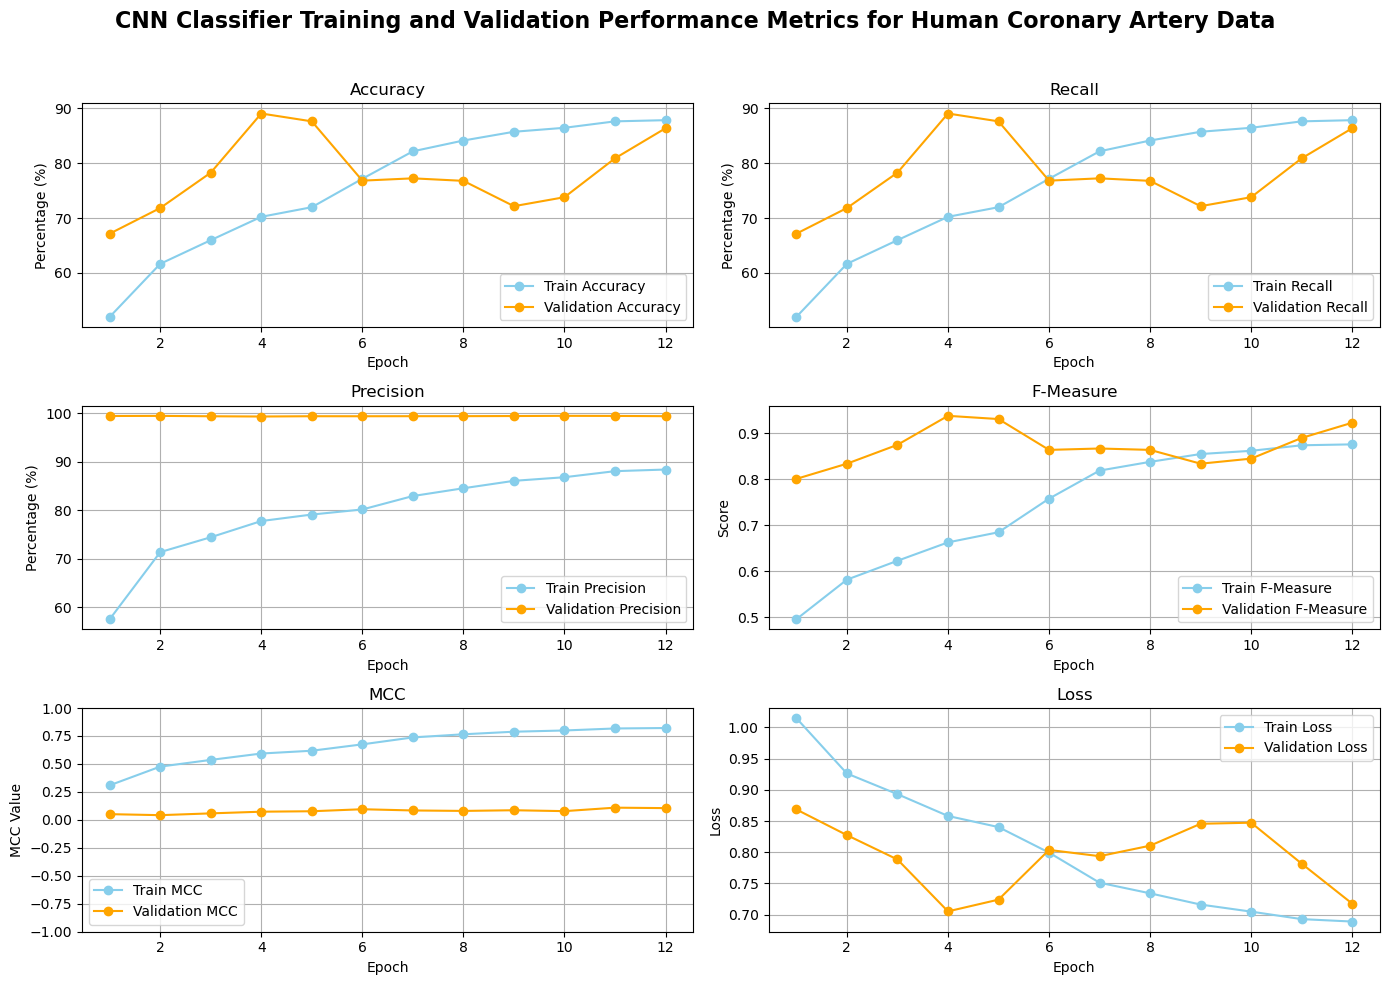

In [3]:
# Create Performance Metric graphs of training and validation (fine-tunig step) with Human Coronary Artery Data

# Metrics data
epochs = np.arange(1, 13)

# Training results
train_accuracy = [52.006, 61.660, 65.970, 70.220, 71.969, 77.145, 82.141, 84.105, 85.699, 86.421, 87.593, 87.808]
train_recall = [52.006, 61.660, 65.970, 70.220, 71.969, 77.145, 82.141, 84.105, 85.699, 86.421, 87.593, 87.808]
train_precision = [57.501, 71.356, 74.425, 77.771, 79.112, 80.160, 82.933, 84.541, 86.073, 86.819, 88.069, 88.404]
train_fmeasure = [0.496, 0.582, 0.623, 0.663, 0.685, 0.758, 0.819, 0.838, 0.855, 0.862, 0.874, 0.876]
train_mcc = [0.309, 0.476, 0.536, 0.593, 0.618, 0.675, 0.737, 0.765, 0.788, 0.799, 0.817, 0.821]
train_loss = [1.0147, 0.9261, 0.8930, 0.8581, 0.8403, 0.7994, 0.7512, 0.7342, 0.7162, 0.7049, 0.6929, 0.6890]

# Validation results
val_accuracy = [67.151, 71.821, 78.254, 89.023, 87.594, 76.802, 77.223, 76.764, 72.155, 73.791, 80.863, 86.337]
val_recall = [67.151, 71.821, 78.254, 89.023, 87.594, 76.802, 77.223, 76.764, 72.155, 73.791, 80.863, 86.337]
val_precision = [99.459, 99.483, 99.402, 99.352, 99.411, 99.407, 99.418, 99.424, 99.452, 99.492, 99.472, 99.419]
val_fmeasure = [0.801, 0.834, 0.875, 0.938, 0.931, 0.864, 0.867, 0.864, 0.834, 0.845, 0.890, 0.923]
val_mcc = [0.051, 0.042, 0.058, 0.073, 0.077, 0.095, 0.084, 0.080, 0.086, 0.078, 0.109, 0.105]
val_loss = [0.8685, 0.8274, 0.7884, 0.7053, 0.7241, 0.8037, 0.7937, 0.8105, 0.8456, 0.8473, 0.7817, 0.7177]

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('CNN Classifier Training and Validation Performance Metrics for Human Coronary Artery Data', fontsize=16, fontweight='bold')

# Plot for Accuracy
axs[0, 0].plot(epochs, train_accuracy, label='Train Accuracy', color='skyblue', marker='o')
axs[0, 0].plot(epochs, val_accuracy, label='Validation Accuracy', color='orange', marker='o')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Percentage (%)')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot for Recall
axs[0, 1].plot(epochs, train_recall, label='Train Recall', color='skyblue', marker='o')
axs[0, 1].plot(epochs, val_recall, label='Validation Recall', color='orange', marker='o')
axs[0, 1].set_title('Recall')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Percentage (%)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot for Precision
axs[1, 0].plot(epochs, train_precision, label='Train Precision', color='skyblue', marker='o')
axs[1, 0].plot(epochs, val_precision, label='Validation Precision', color='orange', marker='o')
axs[1, 0].set_title('Precision')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Percentage (%)')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot for F-Measure
axs[1, 1].plot(epochs, train_fmeasure, label='Train F-Measure', color='skyblue', marker='o')
axs[1, 1].plot(epochs, val_fmeasure, label='Validation F-Measure', color='orange', marker='o')
axs[1, 1].set_title('F-Measure')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Score')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Plot for MCC
axs[2, 0].plot(epochs, train_mcc, label='Train MCC', color='skyblue', marker='o')
axs[2, 0].plot(epochs, val_mcc, label='Validation MCC', color='orange', marker='o')
axs[2, 0].set_title('MCC')
axs[2, 0].set_xlabel('Epoch')
axs[2, 0].set_ylabel('MCC Value')
axs[2, 0].set_ylim(-1, 1)
axs[2, 0].legend()
axs[2, 0].grid(True)

# Plot for Loss
axs[2, 1].plot(epochs, train_loss, label='Train Loss', color='skyblue', marker='o')
axs[2, 1].plot(epochs, val_loss, label='Validation Loss', color='orange', marker='o')
axs[2, 1].set_title('Loss')
axs[2, 1].set_xlabel('Epoch')
axs[2, 1].set_ylabel('Loss')
axs[2, 1].legend()
axs[2, 1].grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [12]:
# Testing the model 

Project='Pigdata_rawcounts'

performance_by_dataset=[]
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
MyModelName='Model_TL.pth'
my_model = MyNetwork()
my_model.load_state_dict(torch.load(MyModelName))
my_model.eval()
test_dataset = CancerDataset_global_pooled_multi_datasets_all.MyDataset(data_type=Project,case='testing',transform=DatasetTransform_global_pooled_all.Compose([DatasetTransform_global_pooled_all.ArrayToTensor()]))
batch_size = 256
# samples=test_dataset.len
samples = len(test_dataset)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
accuracy,recall, precision,fmeasure,mcc=test(model,Project)
Test_results='Test results for '+Project+': accuarcy: '+str(accuracy)+' recall: '+str(recall)+' precision: '+str(precision)+' fmeasure: '+str(fmeasure)+' mcc: '+str(mcc)
print(Test_results)
performance_by_dataset=np.append(performance_by_dataset,Test_results)

loading dataset
 Pig Test dataset loading
[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [0.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.

/data/home/ex23398/.conda/envs/libinstall_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


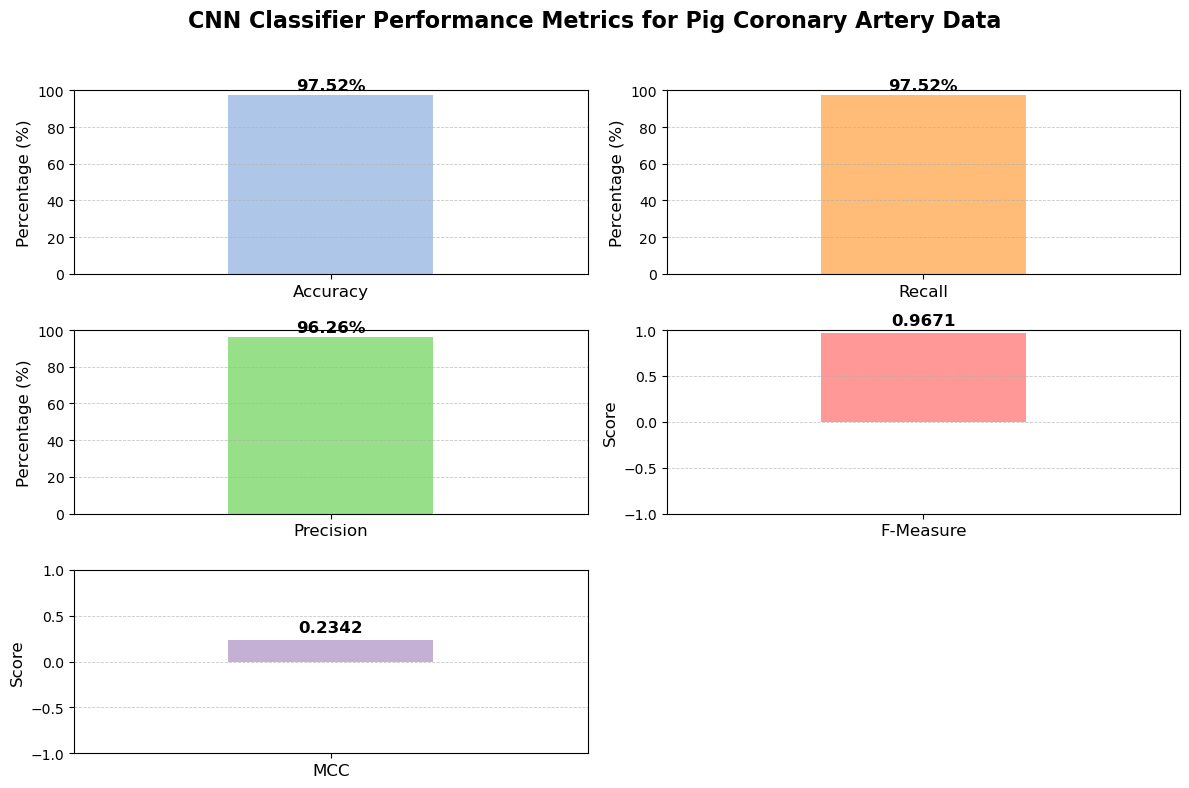

In [4]:
# Plot performance metric for the pig data

# Metrics data
metrics = {
    'Accuracy': 97.5177600931677,
    'Recall': 97.5177600931677,
    'Precision': 96.25830569502816,
    'F-Measure': 0.9670902732222625,
    'MCC': 0.2342204881244135
}

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
fig.suptitle('CNN Classifier Performance Metrics for Pig Coronary Artery Data', fontsize=16, fontweight='bold')

# Flatten the axis array for easier iteration
axs = axs.flatten()

# Colors for the bars
colors = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']

# Plot each metric in a separate subplot
for ax, (metric, value), color in zip(axs, metrics.items(), colors):
    ax.bar(0, value, color=color, width=0.4)
    ax.set_xticks([0])  # Set x-ticks
    ax.set_xticklabels([metric], fontsize=12)  # Display metric name below the bar
    ax.set_xlim(-0.5, 0.5)  # Center the bar
    
    # Y-axis limit and value label for each metric
    if metric in ['Accuracy', 'Recall', 'Precision']:
        ax.set_ylim(0, 100)
        ax.text(0, value + 1, f'{value:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
        ax.set_ylabel('Percentage (%)', fontsize=12)
    else:
        ax.set_ylim(-1, 1)  # Adjust for MCC as well
        ax.text(0, value + 0.05, f'{value:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
        ax.set_ylabel('Score', fontsize=12)
    
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.6, alpha=0.7)  # Light grid

# Hide the last empty subplot (since we now have 5 metrics)
axs[-1].axis('off')

# Adjust layout to fit well
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


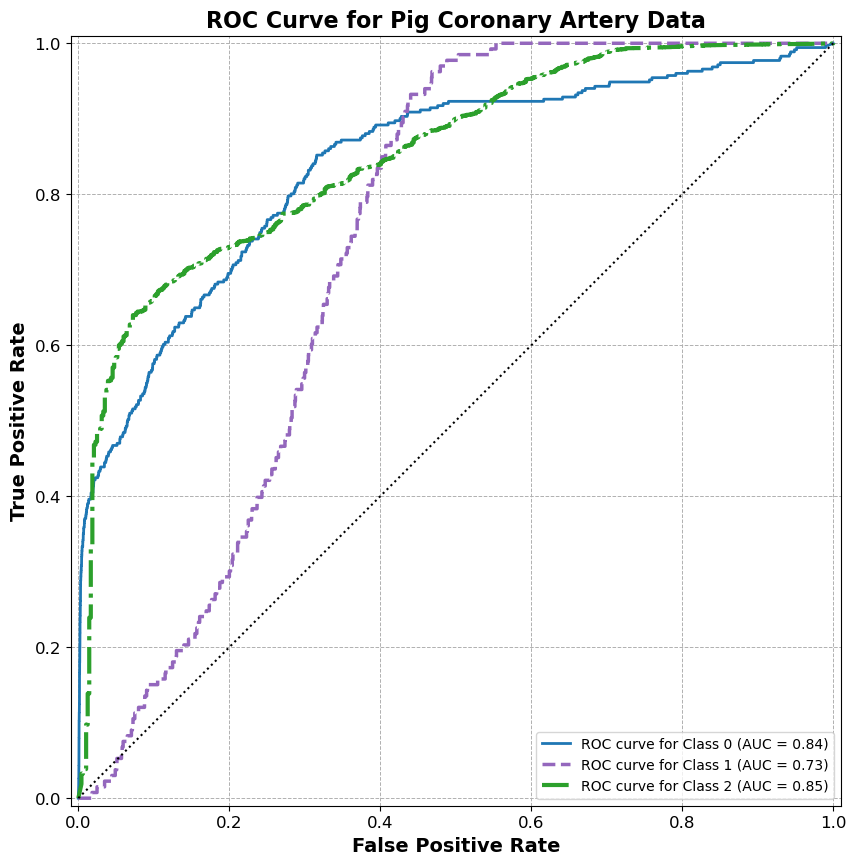

In [3]:
# Plotting AUROC 
Project = 'Pigdata_rawcounts'
File = 'Test_predicted_probs_' + str(Project) + '.txt'
y_pred = np.loadtxt(File, delimiter=',', dtype=np.float32)
prob_predict3D = y_pred.reshape((-1, 3))
pred_0 = prob_predict3D

File = 'Pigdata_rawcounts_test_label.txt'
y_true = np.loadtxt(File, delimiter=',', dtype=np.float32)
y_true_b = label_binarize(y_true, classes=[0, 1, 2])
n_classes = y_true_b.shape[1]
n_classes = 3  # Total number of classes

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_b[:, i], pred_0[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Create the figure
fig, ax = plt.subplots(figsize=(10, 10))

# Custom colors for each class
colors = ["#1f77b4", "#9467bd", "#2ca02c"]  # Blue, Purple, Green
line_styles = ['-', '--', '-.']  # Different line styles for each class
line_widths = [2, 2.5, 3]  # Varying line widths

for class_id, color, ls, lw in zip(range(n_classes), colors, line_styles, line_widths):
    RocCurveDisplay.from_predictions(
        y_true_b[:, class_id],
        pred_0[:, class_id],
        name=f"ROC curve for Class {class_id}",
        color=color,
        linestyle=ls,
        linewidth=lw,
        ax=ax,
    ) 

# Adding a diagonal reference line
plt.plot([0, 1], [0, 1], color='black', lw=1.5, linestyle=':')

# Customize axis labels and title
ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax.set_title('ROC Curve for Pig Coronary Artery Data', fontsize=16, fontweight='bold')

# Adjusting ticks and grid
ax.tick_params(axis='both', labelsize=12)
plt.grid(True, linestyle='--', linewidth=0.7)

# Save the plot as a PNG file
plt.savefig('ROC Curve for Pig Coronary Artery Data.png', dpi=300)
plt.show()


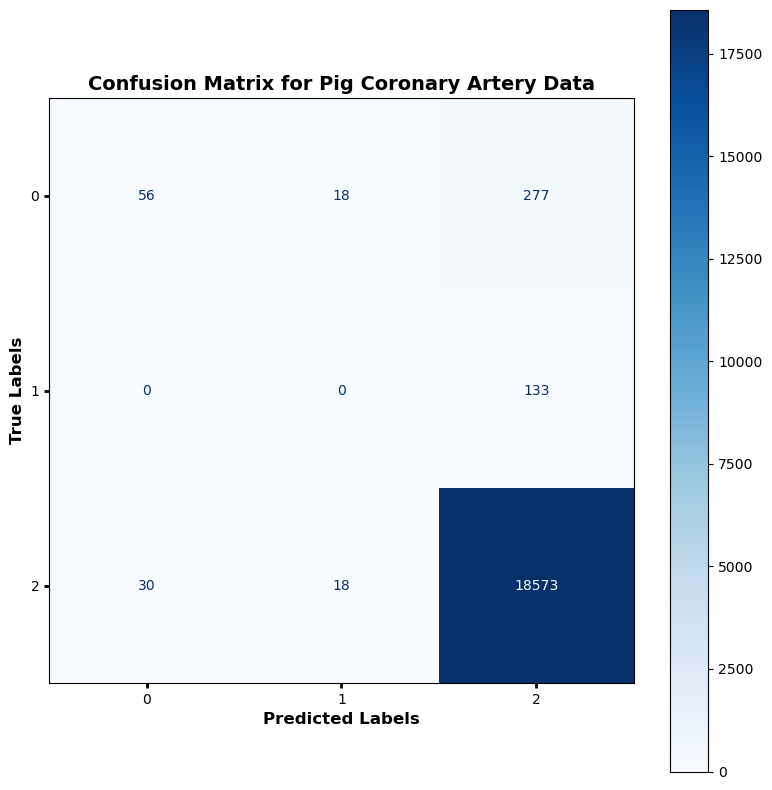

In [22]:
# Generate a Confusion Matrix

# Load the predicted labels
File = 'Test_predicted_labels_' + str(Project) + '.txt'
y_pred = np.loadtxt(File, delimiter=',', dtype=np.float32)

# Load the true labels
File = 'Pigdata_rawcounts_test_label.txt'
y_true = np.loadtxt(File, delimiter=',', dtype=np.float32)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Create ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(conf_matrix)

# Plot with visual enhancements
fig, ax = plt.subplots(figsize=(8, 8))

# Customize color map and set labels
disp.plot(cmap="Blues", ax=ax, values_format='.0f')  # Using a blue colormap and formatting values

# Customize title and axis labels
plt.title('Confusion Matrix for Pig Coronary Artery Data', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
plt.ylabel('True Labels', fontsize=12, fontweight='bold')

# Customize tick labels
ax.tick_params(axis='both', labelsize=10, width=2)

# Customize colorbar
cbar = ax.get_images()[0].colorbar
cbar.ax.tick_params(labelsize=10)

# Adjust the layout
plt.tight_layout()

# Save the plot as PNG file
plt.savefig('Confusion_Matrix_Pig_Coronary_Artery_Data.png', dpi=300)

# Show the plot
plt.show()
